In [66]:
import pandas as pd
import numpy as np
import duckdb
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

modelling_conn = duckdb.connect('modelling_db')

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [67]:
def treinar_modelos_precipitacao(
    abt_estacoes_vizinhas,
    threshold_prioridade,
    percent_datetime_partitioning_split,
    featurelist_com_vizinha,
    featurelist_sem_vizinha
):
    # Separar com e sem vizinha
    abt_com_vizinha = abt_estacoes_vizinhas.loc[
        abt_estacoes_vizinhas['vl_prioridade_vizinha'] >= threshold_prioridade
    ].sort_values(by=['id_estacao','dt_medicao'])

    abt_sem_vizinha = abt_estacoes_vizinhas.loc[
        abt_estacoes_vizinhas['vl_prioridade_vizinha'].fillna(0) < threshold_prioridade
    ].sort_values(by=['id_estacao','dt_medicao'])

    # Split por estação
    treinamento_com_vizinha = abt_com_vizinha.groupby('id_estacao', as_index=False).apply(
        lambda g: g.iloc[:max(1, int(len(g) * percent_datetime_partitioning_split))]
    ).reset_index(drop=True)

    validacao_com_vizinha = abt_com_vizinha.groupby('id_estacao', as_index=False).apply(
        lambda g: g.iloc[max(1, int(len(g) * percent_datetime_partitioning_split)):]
    ).reset_index(drop=True)

    treinamento_sem_vizinha = abt_sem_vizinha.groupby('id_estacao', as_index=False).apply(
        lambda g: g.iloc[:max(1, int(len(g) * percent_datetime_partitioning_split))]
    ).reset_index(drop=True)

    validacao_sem_vizinha = abt_sem_vizinha.groupby('id_estacao', as_index=False).apply(
        lambda g: g.iloc[max(1, int(len(g) * percent_datetime_partitioning_split)):]
    ).reset_index(drop=True)

    # Features e target
    X_com_vizinha_treino = treinamento_com_vizinha[featurelist_com_vizinha]
    y_com_vizinha_treino = treinamento_com_vizinha['vl_precipitacao']
    X_sem_vizinha_treino = treinamento_sem_vizinha[featurelist_sem_vizinha]
    y_sem_vizinha_treino = treinamento_sem_vizinha['vl_precipitacao']

    params = {
        "tree_method": "gpu_hist",     # ativa GPU
        "predictor": "gpu_predictor"  # também força a predição na GPU
    }

    # Treinar modelos
    xgboost_com_vizinha = XGBRegressor(**params)
    xgboost_sem_vizinha = XGBRegressor(**params)

    xgboost_com_vizinha.fit(X_com_vizinha_treino, y_com_vizinha_treino)
    xgboost_sem_vizinha.fit(X_sem_vizinha_treino, y_sem_vizinha_treino)

    # Validação
    X_com_vizinha_valid = validacao_com_vizinha[featurelist_com_vizinha]
    y_com_vizinha_valid = validacao_com_vizinha['vl_precipitacao']
    X_sem_vizinha_valid = validacao_sem_vizinha[featurelist_sem_vizinha]
    y_sem_vizinha_valid = validacao_sem_vizinha['vl_precipitacao']

    y_com_vizinha_pred = xgboost_com_vizinha.predict(X_com_vizinha_valid)
    y_sem_vizinha_pred = xgboost_sem_vizinha.predict(X_sem_vizinha_valid)

    # Métricas
    metrics = {
        "com_vizinha": {
            "model": xgboost_com_vizinha,
            "mse": mean_squared_error(y_com_vizinha_valid, y_com_vizinha_pred),
            "rmse": np.sqrt(mean_squared_error(y_com_vizinha_valid, y_com_vizinha_pred)),
            "mae": mean_absolute_error(y_com_vizinha_valid, y_com_vizinha_pred),
            "r2": r2_score(y_com_vizinha_valid, y_com_vizinha_pred)
        },
        "sem_vizinha": {
            "model": xgboost_sem_vizinha,
            "mse": mean_squared_error(y_sem_vizinha_valid, y_sem_vizinha_pred),
            "rmse": np.sqrt(mean_squared_error(y_sem_vizinha_valid, y_sem_vizinha_pred)),
            "mae": mean_absolute_error(y_sem_vizinha_valid, y_sem_vizinha_pred),
            "r2": r2_score(y_sem_vizinha_valid, y_sem_vizinha_pred)
        }
    }

    return metrics

In [59]:
threshold_prioridade = 0.5
percent_datetime_partitioning_split = 0.7

featurelist_com_vizinha = ['latitude','longitude','dt_medicao_mes', 'dt_medicao_ano',
                           'vl_declividade', 'vl_altitude', 'vl_distancia_oceano', 'vl_aspecto_relevo',
                           'vl_temperatura_maxima', 'vl_temperatura_media','vl_temperatura_minima', 'vl_umidade_relativa_maxima','vl_umidade_relativa_media', 'vl_umidade_relativa_minima','vl_velocidade_vento_2m_maxima', 'vl_velocidade_vento_2m_media','vl_velocidade_vento_10m_media', 
                           'vl_precipitacao_chirps','vl_precipitacao_cpc', 'vl_temperatura_maxima_cpc','vl_temperatura_minima_cpc', 'vl_precipitacao_gpm_final_run','vl_precipitacao_gpm_late_run', 
                           'vl_precipitacao_power','vl_temperatura_maxima_2m_K_power', 'vl_temperatura_media_2m_K_power','vl_temperatura_minima_2m_K_power', 'vl_umidade_relativa_2m_power','vl_pressao_nivel_superficie_power', 'vl_irradiancia_allsky_power','vl_direcao_vento_10m_power', 
                           'vl_direcao_vento_2m_power','vl_temperatura_orvalho_2m_K_power', 'vl_vento_10m_power','vl_vento_medio_2m_power', 'vl_vento_maximo_2m_power','vl_vento_maximo_10m_power', 
                           'vl_precipitacao_vizinha','vl_prioridade_vizinha']

featurelist_sem_vizinha = ['latitude','longitude','dt_medicao_mes', 'dt_medicao_ano',
                           'vl_declividade', 'vl_altitude', 'vl_distancia_oceano', 'vl_aspecto_relevo',
                           'vl_temperatura_maxima', 'vl_temperatura_media','vl_temperatura_minima', 'vl_umidade_relativa_maxima','vl_umidade_relativa_media', 'vl_umidade_relativa_minima','vl_velocidade_vento_2m_maxima', 'vl_velocidade_vento_2m_media','vl_velocidade_vento_10m_media', 
                           'vl_precipitacao_chirps','vl_precipitacao_cpc', 'vl_temperatura_maxima_cpc','vl_temperatura_minima_cpc', 'vl_precipitacao_gpm_final_run','vl_precipitacao_gpm_late_run', 
                           'vl_precipitacao_power','vl_temperatura_maxima_2m_K_power', 'vl_temperatura_media_2m_K_power','vl_temperatura_minima_2m_K_power', 'vl_umidade_relativa_2m_power','vl_pressao_nivel_superficie_power', 'vl_irradiancia_allsky_power','vl_direcao_vento_10m_power', 
                           'vl_direcao_vento_2m_power','vl_temperatura_orvalho_2m_K_power', 'vl_vento_10m_power','vl_vento_medio_2m_power', 'vl_vento_maximo_2m_power','vl_vento_maximo_10m_power']

abt_estacoes_vizinhas = modelling_conn.execute("""
SELECT * FROM abt_estacoes_vizinhas
""").fetchdf()

abt_estacoes_vizinhas['dt_medicao_mes'] = abt_estacoes_vizinhas['dt_medicao'].dt.month
abt_estacoes_vizinhas['dt_medicao_ano'] = abt_estacoes_vizinhas['dt_medicao'].dt.year

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [ ]:
resultados_lista = []

for threshold in np.arange(0.7, 1.0, 0.01):
    print(f"\n=== Treinando modelos com threshold_prioridade = {threshold:.3f} ===")
    resultados = treinar_modelos_precipitacao(
        abt_estacoes_vizinhas=abt_estacoes_vizinhas,
        threshold_prioridade=threshold,
        percent_datetime_partitioning_split=percent_datetime_partitioning_split,
        featurelist_com_vizinha=featurelist_com_vizinha,
        featurelist_sem_vizinha=featurelist_sem_vizinha
    )
    
    resultados_lista.append({
        'threshold_prioridade': threshold,
        'rmse_com_vizinha': resultados['com_vizinha']['rmse'],
        'mae_com_vizinha': resultados['com_vizinha']['mae'],
        'r2_com_vizinha': resultados['com_vizinha']['r2'],
        'rmse_sem_vizinha': resultados['sem_vizinha']['rmse'],
        'mae_sem_vizinha': resultados['sem_vizinha']['mae'],
        'r2_sem_vizinha': resultados['sem_vizinha']['r2']
    })



=== Treinando modelos com threshold_prioridade = 0.5 ===


C:\Users\Mateus Santos Rochas\AppData\Local\Temp\ipykernel_3872\3537958185.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  treinamento_com_vizinha = abt_com_vizinha.groupby('id_estacao', as_index=False).apply(
C:\Users\Mateus Santos Rochas\AppData\Local\Temp\ipykernel_3872\3537958185.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  validacao_com_vizinha = abt_com_vizinha.groupby('id_estacao', as_in


=== Treinando modelos com threshold_prioridade = 0.5 ===


C:\Users\Mateus Santos Rochas\AppData\Local\Temp\ipykernel_3872\3537958185.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  treinamento_com_vizinha = abt_com_vizinha.groupby('id_estacao', as_index=False).apply(
C:\Users\Mateus Santos Rochas\AppData\Local\Temp\ipykernel_3872\3537958185.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  validacao_com_vizinha = abt_com_vizinha.groupby('id_estacao', as_in


=== Treinando modelos com threshold_prioridade = 0.6 ===


C:\Users\Mateus Santos Rochas\AppData\Local\Temp\ipykernel_3872\3537958185.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  treinamento_com_vizinha = abt_com_vizinha.groupby('id_estacao', as_index=False).apply(
C:\Users\Mateus Santos Rochas\AppData\Local\Temp\ipykernel_3872\3537958185.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  validacao_com_vizinha = abt_com_vizinha.groupby('id_estacao', as_in


=== Treinando modelos com threshold_prioridade = 0.6 ===


C:\Users\Mateus Santos Rochas\AppData\Local\Temp\ipykernel_3872\3537958185.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  treinamento_com_vizinha = abt_com_vizinha.groupby('id_estacao', as_index=False).apply(
C:\Users\Mateus Santos Rochas\AppData\Local\Temp\ipykernel_3872\3537958185.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  validacao_com_vizinha = abt_com_vizinha.groupby('id_estacao', as_in


=== Treinando modelos com threshold_prioridade = 0.6 ===


C:\Users\Mateus Santos Rochas\AppData\Local\Temp\ipykernel_3872\3537958185.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  treinamento_com_vizinha = abt_com_vizinha.groupby('id_estacao', as_index=False).apply(
C:\Users\Mateus Santos Rochas\AppData\Local\Temp\ipykernel_3872\3537958185.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  validacao_com_vizinha = abt_com_vizinha.groupby('id_estacao', as_in


=== Treinando modelos com threshold_prioridade = 0.6 ===


C:\Users\Mateus Santos Rochas\AppData\Local\Temp\ipykernel_3872\3537958185.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  treinamento_com_vizinha = abt_com_vizinha.groupby('id_estacao', as_index=False).apply(
C:\Users\Mateus Santos Rochas\AppData\Local\Temp\ipykernel_3872\3537958185.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  validacao_com_vizinha = abt_com_vizinha.groupby('id_estacao', as_in


=== Treinando modelos com threshold_prioridade = 0.7 ===


C:\Users\Mateus Santos Rochas\AppData\Local\Temp\ipykernel_3872\3537958185.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  treinamento_com_vizinha = abt_com_vizinha.groupby('id_estacao', as_index=False).apply(
C:\Users\Mateus Santos Rochas\AppData\Local\Temp\ipykernel_3872\3537958185.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  validacao_com_vizinha = abt_com_vizinha.groupby('id_estacao', as_in


=== Treinando modelos com threshold_prioridade = 0.7 ===


C:\Users\Mateus Santos Rochas\AppData\Local\Temp\ipykernel_3872\3537958185.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  treinamento_com_vizinha = abt_com_vizinha.groupby('id_estacao', as_index=False).apply(
C:\Users\Mateus Santos Rochas\AppData\Local\Temp\ipykernel_3872\3537958185.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  validacao_com_vizinha = abt_com_vizinha.groupby('id_estacao', as_in


=== Treinando modelos com threshold_prioridade = 0.7 ===


C:\Users\Mateus Santos Rochas\AppData\Local\Temp\ipykernel_3872\3537958185.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  treinamento_com_vizinha = abt_com_vizinha.groupby('id_estacao', as_index=False).apply(
C:\Users\Mateus Santos Rochas\AppData\Local\Temp\ipykernel_3872\3537958185.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  validacao_com_vizinha = abt_com_vizinha.groupby('id_estacao', as_in


=== Treinando modelos com threshold_prioridade = 0.7 ===


C:\Users\Mateus Santos Rochas\AppData\Local\Temp\ipykernel_3872\3537958185.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  treinamento_com_vizinha = abt_com_vizinha.groupby('id_estacao', as_index=False).apply(
C:\Users\Mateus Santos Rochas\AppData\Local\Temp\ipykernel_3872\3537958185.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  validacao_com_vizinha = abt_com_vizinha.groupby('id_estacao', as_in


=== Treinando modelos com threshold_prioridade = 0.8 ===


C:\Users\Mateus Santos Rochas\AppData\Local\Temp\ipykernel_3872\3537958185.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  treinamento_com_vizinha = abt_com_vizinha.groupby('id_estacao', as_index=False).apply(
C:\Users\Mateus Santos Rochas\AppData\Local\Temp\ipykernel_3872\3537958185.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  validacao_com_vizinha = abt_com_vizinha.groupby('id_estacao', as_in


=== Treinando modelos com threshold_prioridade = 0.8 ===


C:\Users\Mateus Santos Rochas\AppData\Local\Temp\ipykernel_3872\3537958185.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  treinamento_com_vizinha = abt_com_vizinha.groupby('id_estacao', as_index=False).apply(
C:\Users\Mateus Santos Rochas\AppData\Local\Temp\ipykernel_3872\3537958185.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  validacao_com_vizinha = abt_com_vizinha.groupby('id_estacao', as_in


=== Treinando modelos com threshold_prioridade = 0.8 ===


C:\Users\Mateus Santos Rochas\AppData\Local\Temp\ipykernel_3872\3537958185.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  treinamento_com_vizinha = abt_com_vizinha.groupby('id_estacao', as_index=False).apply(
C:\Users\Mateus Santos Rochas\AppData\Local\Temp\ipykernel_3872\3537958185.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  validacao_com_vizinha = abt_com_vizinha.groupby('id_estacao', as_in


=== Treinando modelos com threshold_prioridade = 0.8 ===


C:\Users\Mateus Santos Rochas\AppData\Local\Temp\ipykernel_3872\3537958185.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  treinamento_com_vizinha = abt_com_vizinha.groupby('id_estacao', as_index=False).apply(
C:\Users\Mateus Santos Rochas\AppData\Local\Temp\ipykernel_3872\3537958185.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  validacao_com_vizinha = abt_com_vizinha.groupby('id_estacao', as_in


=== Treinando modelos com threshold_prioridade = 0.9 ===


C:\Users\Mateus Santos Rochas\AppData\Local\Temp\ipykernel_3872\3537958185.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  treinamento_com_vizinha = abt_com_vizinha.groupby('id_estacao', as_index=False).apply(
C:\Users\Mateus Santos Rochas\AppData\Local\Temp\ipykernel_3872\3537958185.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  validacao_com_vizinha = abt_com_vizinha.groupby('id_estacao', as_in


=== Treinando modelos com threshold_prioridade = 0.9 ===


C:\Users\Mateus Santos Rochas\AppData\Local\Temp\ipykernel_3872\3537958185.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  treinamento_com_vizinha = abt_com_vizinha.groupby('id_estacao', as_index=False).apply(
C:\Users\Mateus Santos Rochas\AppData\Local\Temp\ipykernel_3872\3537958185.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  validacao_com_vizinha = abt_com_vizinha.groupby('id_estacao', as_in


=== Treinando modelos com threshold_prioridade = 0.9 ===


C:\Users\Mateus Santos Rochas\AppData\Local\Temp\ipykernel_3872\3537958185.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  treinamento_com_vizinha = abt_com_vizinha.groupby('id_estacao', as_index=False).apply(
C:\Users\Mateus Santos Rochas\AppData\Local\Temp\ipykernel_3872\3537958185.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  validacao_com_vizinha = abt_com_vizinha.groupby('id_estacao', as_in


=== Treinando modelos com threshold_prioridade = 0.9 ===


C:\Users\Mateus Santos Rochas\AppData\Local\Temp\ipykernel_3872\3537958185.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  treinamento_com_vizinha = abt_com_vizinha.groupby('id_estacao', as_index=False).apply(
C:\Users\Mateus Santos Rochas\AppData\Local\Temp\ipykernel_3872\3537958185.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  validacao_com_vizinha = abt_com_vizinha.groupby('id_estacao', as_in


=== Treinando modelos com threshold_prioridade = 1.0 ===


C:\Users\Mateus Santos Rochas\AppData\Local\Temp\ipykernel_3872\3537958185.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  treinamento_com_vizinha = abt_com_vizinha.groupby('id_estacao', as_index=False).apply(
C:\Users\Mateus Santos Rochas\AppData\Local\Temp\ipykernel_3872\3537958185.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  validacao_com_vizinha = abt_com_vizinha.groupby('id_estacao', as_in


=== Treinando modelos com threshold_prioridade = 1.0 ===


C:\Users\Mateus Santos Rochas\AppData\Local\Temp\ipykernel_3872\3537958185.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  treinamento_com_vizinha = abt_com_vizinha.groupby('id_estacao', as_index=False).apply(
C:\Users\Mateus Santos Rochas\AppData\Local\Temp\ipykernel_3872\3537958185.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  validacao_com_vizinha = abt_com_vizinha.groupby('id_estacao', as_in

In [62]:
import seaborn as sns
df = pd.DataFrame(resultados_lista)

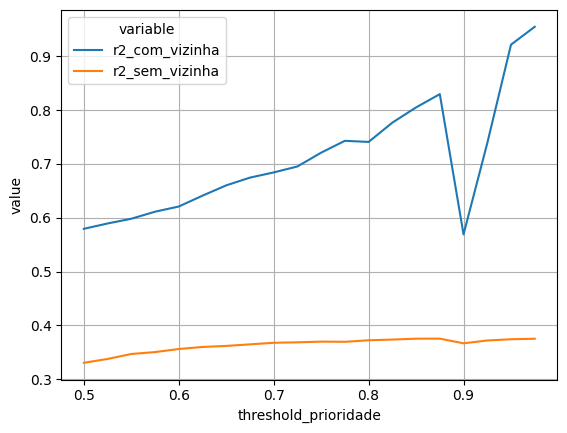

In [ ]:
sns.lineplot(data=pd.melt(df[['threshold_prioridade','r2_com_vizinha','r2_sem_vizinha']],id_vars=['threshold_prioridade']),x='threshold_prioridade',y='value',hue='variable')
plt.grid()

In [83]:
df.loc[df['threshold_prioridade'].round(3)>=0.8]

,threshold_prioridade,rmse_com_vizinha,mae_com_vizinha,r2_com_vizinha,rmse_sem_vizinha,mae_sem_vizinha,r2_sem_vizinha
12,0.800,5.391340,1.936462,0.740817,8.129291,3.464589,0.372205
13,0.825,5.005553,1.807563,0.776640,8.131234,3.447892,0.373529
14,0.850,4.728663,1.580863,0.804962,8.117462,3.438234,0.375167
15,0.875,4.475753,1.423968,0.829646,8.121165,3.428770,0.375288
16,0.900,7.259268,1.953347,0.569036,8.181651,3.483374,0.366559
17,0.925,5.684961,1.517376,0.738486,8.159410,3.451426,0.371837
18,0.950,3.077766,0.875365,0.921576,8.152805,3.460364,0.374130
19,0.975,2.281800,0.569029,0.954798,8.149259,3.449104,0.375081


In [78]:
df

,threshold_prioridade,rmse_com_vizinha,mae_com_vizinha,r2_com_vizinha,rmse_sem_vizinha,mae_sem_vizinha,r2_sem_vizinha
0,0.500,6.686833,2.553807,0.579343,8.436987,3.574266,0.330398
1,0.525,6.619109,2.515728,0.589256,8.363531,3.535510,0.337492
2,0.550,6.560421,2.484593,0.598045,8.298008,3.503113,0.346753
3,0.575,6.457298,2.428558,0.611141,8.272693,3.486361,0.350283
4,0.600,6.390275,2.396257,0.620807,8.227177,3.465207,0.356003
5,0.625,6.223513,2.316301,0.640925,8.211218,3.450583,0.359786
6,0.650,6.057387,2.228712,0.660103,8.200400,3.446324,0.361712
7,0.675,5.935043,2.166480,0.674471,8.180419,3.441818,0.364641
8,0.700,5.881715,2.148508,0.684126,8.151472,3.432174,0.367556
9,0.725,5.803908,2.073865,0.695214,8.141697,3.442676,0.368411


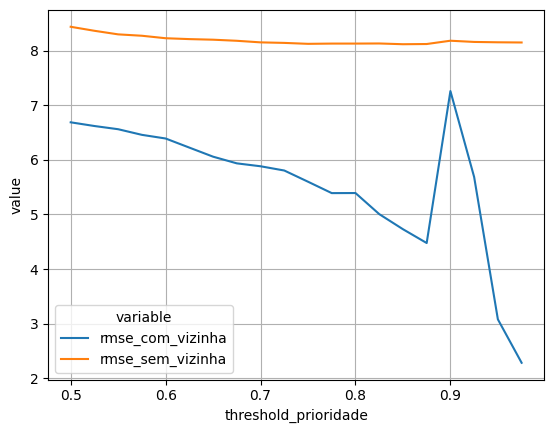

In [65]:
sns.lineplot(data=pd.melt(df[['threshold_prioridade','rmse_com_vizinha','rmse_sem_vizinha']],id_vars=['threshold_prioridade']),x='threshold_prioridade',y='value',hue='variable')
plt.grid()

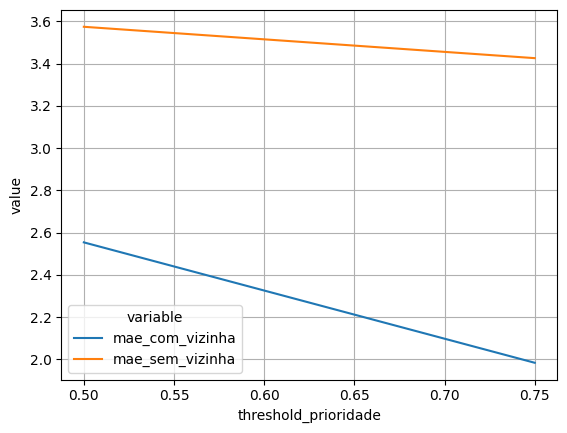

In [ ]:
sns.lineplot(data=pd.melt(df[['threshold_prioridade','mae_com_vizinha','mae_sem_vizinha']],id_vars=['threshold_prioridade']),x='threshold_prioridade',y='value',hue='variable')
plt.grid()

In [ ]:
len(abt_estacoes_vizinhas.loc[abt_estacoes_vizinhas['vl_prioridade_vizinha']>=0.8])

2581500

In [ ]:
len(abt_estacoes_vizinhas.loc[abt_estacoes_vizinhas['vl_prioridade_vizinha']<0.8])

15579506

In [ ]:
# threshold = 0.5
# Modelo com vizinha:
#   MSE : 44.7095
#   RMSE: 6.6865
#   MAE : 2.5537
#   R²  : 0.5794

# Modelo sem vizinha:
#   MSE : 71.1782
#   RMSE: 8.4367
#   MAE : 3.5742
#   R²  : 0.3304


# Paralelizando

In [88]:
!pip install --upgrade tqdm



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\Mateus Santos Rochas\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
